# MEA validation

In this notebook, we import PICS phase 1 data into the phase 2 MEA rebuild. The purpose is to validate that the phase 2 MEA rebuild output is coherent with phase 1 MEA output.

In [1]:
import mdbread
#import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from functools import partial

%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display

In [2]:
def read_basenames(path):
    return [line.lower().strip().split(' ')[0] 
        for line in open(path, 'r') if not line.startswith('#')]

def discount(x, dr, col, ref_year=2017):
    return x[col] / pow(1 + dr, x['year'] - ref_year)   

In [3]:
dat_path = '../dat'
mea_db_path = dat_path + '/validate/mea_validate.db'
cat_db_path = dat_path + '/validate'
cat_db_name = 'results_validate.db'

basenames = [float(x[-2:]) for x in read_basenames(dat_path+'/basenames.txt')]

In [4]:
min_time, max_time = 2017, 2050 # ***
filter_time = True
ref_year = 2017 # ***
fms_emit_factor = 1. # 0.000001

In [5]:
sn1 = 'CBM_Base_HWP_Base'
sn2 = 'CBM_D_HWP_LLP'
unit = '110001'
year = 2017

In [6]:
pcfms_tn = 'pricecost_fms'
pchwp_tn = 'pricecost_hwp'
pcdis_tn = 'pricecost_dis'

Equivalent of UpdateAssumptionsInMEA()

In [7]:
# discount rates (extracted from db.tblDiscountRates)
params_dr = {'dr_soci_econ':0.03,
             'dr_soci_emit':0.01,
             'dr_priv_econ':0.07,
             'dr_priv_emit':0.00}

# displacement factors (extracted from tblDisplacementFactors)
params_df = {'sawnwood_m3':{'concrete':3.46, 'steel':0.59}, # ***
             'panels_m3':{'concrete':3.89, 'steel':0.85}}   # ***

In [8]:
scen_col = 'scenario'
unit_col = 'tsa_num'
time_col = 'year'

There are two different scenario aggregation levels (hierarchical).

In [9]:
scenario_names1_ref = 'CBM_BASE'
scenario_names1 = {'CBM_BASE':('_HWP_Base', '_HWP_LLP'),
                   'CBM_D':('_HWP_Base', '_HWP_LLP')}
scenario_names2_ref = 'CBM_Base_HWP_Base'
scenario_names2 = {'CBM_Base_HWP_Base':('CBM_BASE', 
                                        {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_D_HWP_LLP':('CBM_D', 
                                    {'fms':5, 'hwp':6,  'nrg':6, 'ds1':3, 'ds2':3})}

Results where compiled using different assumption sets. Analysis must be repeated for each assumption set.

In [10]:
# load model parameters from database
cnn = sqlite3.connect(mea_db_path)
c = cnn.cursor()

In [11]:
assid_col = 'assumption_id'
df_pcfms = pd.read_sql_query('select * from %s' % pcfms_tn, cnn)
df_pcfms[unit_col] = df_pcfms[unit_col].astype(str)
df_pcfms.set_index([assid_col, unit_col], inplace=True)
df_pcfms.head()

SWLogPrice  HWLogPrice  SalvageLogPrice  ResiduePrice  \
assumption_id tsa_num                                                          
3             110001         53.0        43.0             43.0           0.0   
              110002         53.0        43.0             43.0           0.0   
              110003         53.0        43.0             43.0           0.0   
              110004         53.0        43.0             43.0           0.0   
              110007         53.0        43.0             43.0           0.0   

                       SWLogCost  HWLogCost  SalvageLogCost  ResidueCost  
assumption_id tsa_num                                                     
3             110001   48.369999  38.369999       38.369999          0.0  
              110002   48.369999  38.369999       38.369999          0.0  
              110003   48.369999  38.369999       38.369999          0.0  
              110004   48.369999  38.369999       38.369999          0.0  
              110007   48.369999  38.369999       38.369999          0.0

In [12]:
assid_col = 'assumption_id'
df_pchwp = pd.read_sql_query('select * from %s' % pchwp_tn, cnn)
df_pchwp[unit_col] = df_pchwp[unit_col].astype(str)
df_pchwp.set_index([assid_col, unit_col], inplace=True)
df_pchwp.head()

SawnwoodPrice  PanelPrice  OtherIRPrice  PulpPrice  \
assumption_id tsa_num                                                       
1             110001           130.0       273.0         130.0      831.0   
              110002           130.0       273.0         130.0      831.0   
              110003           130.0       273.0         130.0      831.0   
              110004           130.0       273.0         130.0      831.0   
              110007           130.0       273.0         130.0      831.0   

                       BioenergyFromProductEOLPrice  \
assumption_id tsa_num                                 
1             110001                      64.592514   
              110002                      64.592514   
              110003                      64.592514   
              110004                      64.592514   
              110007                      64.592514   

                       BioenergyFromHarvestPrice  \
assumption_id tsa_num                              
1             110001                   64.592514   
              110002                   64.592514   
              110003                   64.592514   
              110004                   64.592514   
              110007                   64.592514   

                       BioenergyFromHarvestResiduePrice  \
assumption_id tsa_num                                     
1             110001                          64.592514   
              110002                          64.592514   
              110003                          64.592514   
              110004                          64.592514   
              110007                          64.592514   

                       BioenergyFromMillResiduePrice  SawnwoodCost  PanelCost  \
assumption_id tsa_num                                                           
1             110001                       64.592514         110.0      265.0   
              110002                       64.592514         110.0      265.0   
              110003                       64.592514         110.0      265.0   
              110004                       64.592514         110.0      265.0   
              110007                       64.592514         110.0      265.0   

                       OtherIRCost  PulpCost  BioenergyFromProductEOLCost  \
assumption_id tsa_num                                                       
1             110001         110.0     658.0                          0.0   
              110002         110.0     658.0                          0.0   
              110003         110.0     658.0                          0.0   
              110004         110.0     658.0                          0.0   
              110007         110.0     658.0                          0.0   

                       BioenergyFromHarvestCost  \
assumption_id tsa_num                             
1             110001                  95.397598   
              110002                 111.523636   
              110003                  54.663036   
              110004                 104.772491   
              110007                  54.663036   

                       BioenergyFromHarvestResidueCost  \
assumption_id tsa_num                                    
1             110001                         95.397598   
              110002                        111.523636   
              110003                         54.663036   
              110004                        104.772491   
              110007                         54.663036   

                       BioenergyFromMillResidueCost  
assumption_id tsa_num                                
1             110001                            0.0  
              110002                            0.0  
              110003                            0.0  
              110004                            0.0  
              110007                            0.0

In [13]:
assid_col = 'assumption_id'
df_pcdis = pd.read_sql_query('select * from %s' % pcdis_tn, cnn)
df_pcdis[unit_col] = df_pcdis[unit_col].astype(str)
df_pcdis.set_index([assid_col, unit_col], inplace=True)
df_pcdis.head()

ConcretePrice  SteelPrice  EnergyPrice  ConcreteCost  \
assumption_id tsa_num                                                         
2             110001            65.0       834.0    74.238686          64.0   
              110002            65.0       834.0   115.760292          64.0   
              110003            65.0       834.0   120.000000          64.0   
              110004            65.0       834.0   106.263184          64.0   
              110007            65.0       834.0    38.180752          64.0   

                       SteelCost  EnergyCost  
assumption_id tsa_num                         
2             110001       791.0  121.602562  
              110002       791.0  212.397934  
              110003       791.0   63.365952  
              110004       791.0  180.710068  
              110007       791.0   33.990212

In [14]:
prodconv_tn = 'prodconv'
df_prodconv = pd.read_sql_query('select * from %s' % prodconv_tn, cnn)
df_prodconv[unit_col] = df_prodconv[unit_col].astype(str)
df_prodconv.set_index([scen_col, unit_col], inplace=True)

In [15]:
cnn.close()

In [16]:
cnn = sqlite3.connect('%s/%s' % (cat_db_path, cat_db_name))
c = cnn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
[x[0] for x in c.fetchall()]

['dfe_dfp_sector_society_rt',
 'mea_carbon_flux_by_event',
 'mea_carbon_flux_summary',
 'summary_table',
 'production_mea_format']

In [17]:
idx = pd.IndexSlice

In [18]:
results = {}

## Step 1 (compile harvest volumes)

Sum harvest volume by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [19]:
table_name = 'mea_carbon_flux_by_event'
_time_col = 'Year'
groupby_cols = [scen_col, unit_col, time_col]
data_cols = ['Live_SW_Harvest_Vol',
             'Live_HW_Harvest_Vol',
             'Dead_Wood_harvest_Vol',
             'Harvest_Residue_Volume']
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int).astype(str)
result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

#foo[1] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2.keys():
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

results[1] = result
results[1].head()

Live_SW_Harvest_Vol  Live_HW_Harvest_Vol  \
scenario          tsa_num year                                             
CBM_Base_HWP_Base 110001  2017        495425.844423         18655.663850   
                          2018        514510.292748           273.004411   
                          2019        517071.631918             0.000000   
                          2020        518908.243605             0.000000   
                          2021        480615.819313             0.000000   

                                Dead_Wood_harvest_Vol  Harvest_Residue_Volume  
scenario          tsa_num year                                                 
CBM_Base_HWP_Base 110001  2017           12876.402500                     0.0  
                          2018           13807.773780                     0.0  
                          2019           13152.613490                     0.0  
                          2020           12949.215000                     0.0  
                          2021            4437.261247                     0.0

## Step 2 (compile forest ecosystem emissions)

Sum forest ecosystem emissions by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [20]:
table_name = 'dfe_dfp_sector_society_rt'
_time_col = 'Year'
ghg_col = 'forest_mtco2e'
netemit_col = 'net_emissions'
groupby_cols = [scen_col, unit_col, time_col]
data_cols = [netemit_col]
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)

df[unit_col] = df[unit_col].astype(int).astype(str)

df[netemit_col] = df[ghg_col]
result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# foo[2] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2.keys():
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff

result['net_emissions'] *= fms_emit_factor # convert to mtco2e
results[2] = result
results[2].head()

net_emissions
scenario          tsa_num year               
CBM_Base_HWP_Base 110001  2017      -8.985163
                          2018      -9.451595
                          2019      -9.228005
                          2020      -9.203066
                          2021      -8.167534

In [21]:
# table_name = 'mea_carbon_flux_summary'
# _time_col = 'Year'
# ghg_col = 'GHG'
# tohwp_col = 'To_HWP'
# netemit_col = 'net_emissions'
# groupby_cols = [scen_col, unit_col, time_col]
# data_cols = [netemit_col]
# df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
# df[unit_col] = df[unit_col].astype(int).astype(str)
# df[netemit_col] = df[ghg_col] - ((44/12) * df[tohwp_col])
# result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# # HACK #######
# # CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
# if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
# ##############

# foo[2] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2.keys():
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff

# result['net_emissions'] *= fms_emit_factor # convert to mtco2e
# results[2] = result
# results[2].head()

## Step 3 (compile harvested wood products production)

Sum harvested wood products production (sawnwood, panels, other industrial roundwood, pulp and paper) by scenario, spatial unit, time step, and domestic status. Take difference between reference scenario and each non-reference scenario. Take difference between reference scenario and each non-reference scenario.

In [22]:
table_name = 'production_mea_format'
_time_col = 'year'
isdomestic_col = 'is_domestic'
sawnwoodm3_col = 'sawnwood_m3'
panelsm3_col = 'panels_m3'
otherirwm3_col = 'otherirw_m3'
pulppaperodt_col = 'pulppaper_odt'
groupby_cols = [scen_col, unit_col, time_col, isdomestic_col]
data_cols = [sawnwoodm3_col, panelsm3_col, otherirwm3_col, pulppaperodt_col]
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)

# HACK ########
# monkey patch time_col to match other tables
#df = df.rename(columns={time_col:'Year'})
#time_col = 'Year'
#groupby_cols = [scen_col, unit_col, time_col, isdomestic_col]
###############

# HACK ########
# missing tsa_num field, but we can extract values from run_id
df[unit_col] = df.run_id 
###############
df[unit_col] = df[unit_col].astype(int).astype(str)

result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# foo[3] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

#result.loc['CBM_A_HWP_Base'].head()
results[3] = result
results[3].head()

sawnwood_m3     panels_m3  \
scenario          tsa_num year is_domestic                                
CBM_Base_HWP_Base 110001  2017 0              2900.691828   1170.235261   
                               1            169188.470200  48901.044530   
                          2018 0              2909.681786   1173.862108   
                               1            169712.826900  49052.600890   
                          2019 0              2918.671724   1177.488948   

                                             otherirw_m3  pulppaper_odt  
scenario          tsa_num year is_domestic                               
CBM_Base_HWP_Base 110001  2017 0              191.975758    1687.924858  
                               1            12624.439900   73822.564030  
                          2018 0              192.570738    1693.156152  
                               1            12663.566150   74051.358310  
                          2019 0              193.165717    1698.387435

## Step 4 (compile bioenergy production)

Sum bioenergy production (commodities, harvest, harvest residues, mill residues) by scenario, spatial unit, time step, and domestic status. Take difference between reference scenario and each non-reference scenario.

In [23]:
table_name = 'production_mea_format'
_time_col = 'year'
isdomestic_col = 'is_domestic'
bioenergycommoditiesm3_col = 'bioenergycommodities_m3'
bioenergyharvestm3_col = 'bioenergyharvest_m3'
bioenergyharvestresiduem3_col = 'bioenergyharvestresidue_m3'
bioenergymillresiduem3_col = 'bioenergymillresidue_m3'
groupby_cols = [scen_col, unit_col, time_col, isdomestic_col]
nrgm3_cols = [bioenergycommoditiesm3_col, bioenergyharvestm3_col, bioenergyharvestresiduem3_col, bioenergymillresiduem3_col]
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)

# HACK ########
# monkey patch time_col to match other tables
#df = df.rename(columns={time_col:'Year'})
#time_col = 'Year'
#groupby_cols = [scen_col, unit_col, time_col, isdomestic_col]
###############

# HACK ########
# bioenergy data missing (replace with randome integers for now)
#for i in range(len(data_cols)): df[data_cols[i]] = np.random.randint(1, 100, size=len(df))
###############

# HACK ########
# missing tsa_num field, but we can extract values from run_id
df[unit_col] = df.run_id
###############
df[unit_col] = df[unit_col].astype(int).astype(str)

result = df.rename(columns={_time_col:time_col})[groupby_cols+nrgm3_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# foo[4] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

results[4] = result
results[4].head()

bioenergycommodities_m3  \
scenario          tsa_num year is_domestic                            
CBM_Base_HWP_Base 110001  2017 0                                0.0   
                               1                                0.0   
                          2018 0                                0.0   
                               1                                0.0   
                          2019 0                                0.0   

                                            bioenergyharvest_m3  \
scenario          tsa_num year is_domestic                        
CBM_Base_HWP_Base 110001  2017 0                            0.0   
                               1                            0.0   
                          2018 0                            0.0   
                               1                            0.0   
                          2019 0                            0.0   

                                            bioenergyharvestresidue_m3  \
scenario          tsa_num year is_domestic                               
CBM_Base_HWP_Base 110001  2017 0                                   0.0   
                               1                                   0.0   
                          2018 0                                   0.0   
                               1                                   0.0   
                          2019 0                                   0.0   

                                            bioenergymillresidue_m3  
scenario          tsa_num year is_domestic                           
CBM_Base_HWP_Base 110001  2017 0                                0.0  
                               1                                0.0  
                          2018 0                                0.0  
                               1                                0.0  
                          2019 0                                0.0

## Step 5 (compile harvested wood products emissions)

Sum harvested wood products emissions (sawnwood, panels, other industrial roundwood, pulp and paper) by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [24]:
table_name = 'dfe_dfp_sector_society_rt'
_time_col = 'year'
groupby_cols = [scen_col, unit_col, time_col]
data_cols = ['hwp_emissions_domestic_mtco2e', 'hwp_emissions_foreign_mtco2e']
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int).astype(str)

result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# foo[5] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

results[5] = result
results[5].head()

hwp_emissions_domestic_mtco2e  \
scenario          tsa_num year                                  
CBM_Base_HWP_Base 110001  2017                       0.124696   
                          2018                       0.126952   
                          2019                       0.129105   
                          2020                       0.131178   
                          2021                       0.122592   

                                hwp_emissions_foreign_mtco2e  
scenario          tsa_num year                                
CBM_Base_HWP_Base 110001  2017                      0.105846  
                          2018                      0.117874  
                          2019                      0.127836  
                          2020                      0.136205  
                          2021                      0.141389

## Step 6 (compile bioenergy emissions)

Skip this step (included in step 5).

## Step 7 (compile displaced harvested wood products production)

Multiply result from step 3 by appropriate conversion coefficients to derive displaced concrete and steel production.

Note that there is a bug in phase 1 MEA database query that compiles displaced steel and concrete from sawnwood and panel production (i.e., `qryDisplacement_Products_Dif`).

`DisSteelFromPanel` is incorrectly calculated using `SawnwoodSteel` displacement factor. Oops.

Bug has been corrected in local copy of the the phase 1 MEA for validation purposes (makes more sense than deliberately reproducing the bug in the phase 2 MEA). Oops.

Original SQL query string:

```SQL
SELECT qry6.Year, qry6.DefaultSPUID, qry6.IsDomestic, 
Sum(tblDisplacementFactors!SawnwoodConcrete*(qry6!SumOfsawnwood_m3-qry5!SumOfsawnwood_m3)) AS DisConcreteFromSawnwood, 
Sum(tblDisplacementFactors!PanelConcrete*(qry6!SumOfpanels_m3-qry5!SumOfpanels_m3)) AS DisConcreteFromPanel, 
Sum(tblDisplacementFactors!SawnwoodSteel*(qry6!SumOfsawnwood_m3-qry5!SumOfsawnwood_m3)) AS DisSteelFromSawnwood, 
Sum(tblDisplacementFactors!SawnwoodSteel*(qry6!SumOfpanels_m3-qry5!SumOfpanels_m3)) AS DisSteelFromPanel
FROM tblDisplacementFactors, qry6 INNER JOIN qry5 ON (qry6.IsDomestic = qry5.IsDomestic) AND (qry6.DefaultSPUID = qry5.DefaultSPUID) AND (qry6.Year = qry5.Year)
GROUP BY qry6.Year, qry6.DefaultSPUID, qry6.IsDomestic;
```

Corrected SQL query string:

```SQL
SELECT qry6.Year, qry6.DefaultSPUID, qry6.IsDomestic, 
Sum(tblDisplacementFactors!SawnwoodConcrete*(qry6!SumOfsawnwood_m3-qry5!SumOfsawnwood_m3)) AS DisConcreteFromSawnwood, 
Sum(tblDisplacementFactors!PanelConcrete*(qry6!SumOfpanels_m3-qry5!SumOfpanels_m3)) AS DisConcreteFromPanel, 
Sum(tblDisplacementFactors!SawnwoodSteel*(qry6!SumOfsawnwood_m3-qry5!SumOfsawnwood_m3)) AS DisSteelFromSawnwood, 
Sum(tblDisplacementFactors!PanelSteel*(qry6!SumOfpanels_m3-qry5!SumOfpanels_m3)) AS DisSteelFromPanel
FROM tblDisplacementFactors, qry6 INNER JOIN qry5 ON (qry6.IsDomestic = qry5.IsDomestic) AND (qry6.DefaultSPUID = qry5.DefaultSPUID) AND (qry6.Year = qry5.Year)
GROUP BY qry6.Year, qry6.DefaultSPUID, qry6.IsDomestic;
```

In [25]:
df3 = results[3].query("is_domestic == '1'")
df3.index = df3.index.droplevel(3)
df = pd.DataFrame(index=df3.index)
# no displacement of concrete or steel for otherirw or pulppaper...
df['displaced_concrete'] = 0.
df['displaced_concrete'] += df3[sawnwoodm3_col] * params_df[sawnwoodm3_col]['concrete']
df['displaced_concrete'] += df3[panelsm3_col] * params_df[panelsm3_col]['concrete'] 
df['displaced_steel'] = 0.
df['displaced_steel'] += df3[sawnwoodm3_col] * params_df[sawnwoodm3_col]['steel']
df['displaced_steel'] += df3[panelsm3_col] * params_df[panelsm3_col]['steel'] 

df_ref = df.loc[scenario_names2_ref].copy()
for sn in scenario_names2:
    _diff = df.loc[sn] - df_ref
    df.loc[sn].loc[_diff.index] = _diff 

results[7] = df
results[7].head()

displaced_concrete  displaced_steel
scenario          tsa_num year                                     
CBM_Base_HWP_Base 110001  2017                 0.0              0.0
                          2018                 0.0              0.0
                          2019                 0.0              0.0
                          2020                 0.0              0.0
                          2021                 0.0              0.0

## Step 8 (compile displaced bioenergy production)

Multiply result from step 4 by appropriate conversion coefficients to derive displaced energy production.

In [26]:
bioenergycommoditiesm3dis_col = 'bioenergycommodities_m3_dis'
bioenergyharvestm3dis_col = 'bioenergyharvest_m3_dis'
bioenergyharvestresiduem3dis_col = 'bioenergyharvestresidue_m3_dis'
bioenergymillresiduem3dis_col = 'bioenergymillresidue_m3_dis'
bioenergycommoditiesmwh_col = 'bioenergycommodities_mwh'
bioenergyharvestmwh_col = 'bioenergyharvest_mwh'
bioenergyharvestresiduemwh_col = 'bioenergyharvestresidue_mwh'
bioenergymillresiduemwh_col = 'bioenergymillresidue_mwh'
bioenergycommoditiesmwhdis_col = 'bioenergycommodities_mwh_dis'
bioenergyharvestmwhdis_col = 'bioenergyharvest_mwh_dis'
bioenergyharvestresiduemwhdis_col = 'bioenergyharvestresidue_mwh_dis'
bioenergymillresiduemwhdis_col = 'bioenergymillresidue_mwh_dis'
bioenergycommoditiescp_col = 'bioenergycommodities'
bioenergyharvestcp_col = 'bioenergyharvest'
bioenergyharvestresiduecp_col = 'bioenergyharvestresidue'
bioenergymillresiduecp_col = 'bioenergymillresidue'

nrgm3dis_cols = [bioenergycommoditiesm3dis_col, bioenergyharvestm3dis_col, bioenergyharvestresiduem3dis_col, bioenergymillresiduem3dis_col]
nrgmwh_cols = [bioenergycommoditiesmwh_col, bioenergyharvestmwh_col, bioenergyharvestresiduemwh_col, bioenergymillresiduemwh_col]
nrgmwhdis_cols = [bioenergycommoditiesmwhdis_col, bioenergyharvestmwhdis_col, bioenergyharvestresiduemwhdis_col, bioenergymillresiduemwhdis_col]
nrgcp_cols = [bioenergycommoditiescp_col, bioenergyharvestcp_col, bioenergyharvestresiduecp_col, bioenergymillresiduecp_col]
_time_col = 'year'

#result = results[4].query("is_domestic == '1'").drop(columns='is_domestic')
result = results[4].loc[idx[:, :, :, 1], :]
result.index = result.index.droplevel(3)

# compile displaced energy production (mwh)
r = result.copy()
df_ref = r.loc[scenario_names2_ref].copy()
for sn in scenario_names2.keys():
    _diff = r.loc[sn] - df_ref
    r.loc[sn] = _diff.values
r.rename(columns=dict(zip(nrgm3_cols, nrgm3dis_cols)), inplace=True)
result = result.join(r)
result = result.reset_index().set_index([scen_col, unit_col]).join(df_prodconv[nrgcp_cols])
result = result.reset_index().set_index([scen_col, unit_col, time_col])

for cm3, cm3dis, cmwh, cmwhdis, ccp in zip(nrgm3_cols, nrgm3dis_cols, nrgmwh_cols, nrgmwhdis_cols, nrgcp_cols):
    result[cmwh] = result[cm3] * result[ccp]          # bioenergy production
    result[cmwhdis] = result[cm3dis] * result[ccp] # displaced bioenergy production
    
    
results[8] = result.drop(columns=nrgcp_cols)
results[8].head()

bioenergycommodities_m3  bioenergyharvest_m3  \
scenario          tsa_num year                                                 
CBM_Base_HWP_Base 110001  2017                      0.0                  0.0   
                          2018                      0.0                  0.0   
                          2019                      0.0                  0.0   
                          2020                      0.0                  0.0   
                          2021                      0.0                  0.0   

                                bioenergyharvestresidue_m3  \
scenario          tsa_num year                               
CBM_Base_HWP_Base 110001  2017                         0.0   
                          2018                         0.0   
                          2019                         0.0   
                          2020                         0.0   
                          2021                         0.0   

                                bioenergymillresidue_m3  \
scenario          tsa_num year                            
CBM_Base_HWP_Base 110001  2017                      0.0   
                          2018                      0.0   
                          2019                      0.0   
                          2020                      0.0   
                          2021                      0.0   

                                bioenergycommodities_m3_dis  \
scenario          tsa_num year                                
CBM_Base_HWP_Base 110001  2017                          0.0   
                          2018                          0.0   
                          2019                          0.0   
                          2020                          0.0   
                          2021                          0.0   

                                bioenergyharvest_m3_dis  \
scenario          tsa_num year                            
CBM_Base_HWP_Base 110001  2017                      0.0   
                          2018                      0.0   
                          2019                      0.0   
                          2020                      0.0   
                          2021                      0.0   

                                bioenergyharvestresidue_m3_dis  \
scenario          tsa_num year                                   
CBM_Base_HWP_Base 110001  2017                             0.0   
                          2018                             0.0   
                          2019                             0.0   
                          2020                             0.0   
                          2021                             0.0   

                                bioenergymillresidue_m3_dis  \
scenario          tsa_num year                                
CBM_Base_HWP_Base 110001  2017                          0.0   
                          2018                          0.0   
                          2019                          0.0   
                          2020                          0.0   
                          2021                          0.0   

                                bioenergycommodities_mwh  \
scenario          tsa_num year                             
CBM_Base_HWP_Base 110001  2017                       0.0   
                          2018                       0.0   
                          2019                       0.0   
                          2020                       0.0   
                          2021                       0.0   

                                bioenergycommodities_mwh_dis  \
scenario          tsa_num year                                 
CBM_Base_HWP_Base 110001  2017                           0.0   
                          2018                           0.0   
                          2019                           0.0   
                          2020                           0.0   
                          2021                          

## Step 9 (compile displaced harvested wood products emissions)

Sum displaced harvested wood products emissions by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [27]:
table_name = 'dfe_dfp_sector_society_rt'
_time_col = 'year'
#dfpdomesticmtco2e_col = 'dfp_mtco2e_domestic' # backwards name... yuck!
groupby_cols = [scen_col, unit_col, time_col]
data_cols = ['dfp_mtco2e_domestic', 'dfp_mtco2e_foreign']
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int).astype(str)

result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# foo[9] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

results[9] = result
results[9].head()

dfp_mtco2e_domestic  dfp_mtco2e_foreign
scenario          tsa_num year                                         
CBM_Base_HWP_Base 110001  2017            -0.150517           -0.293935
                          2018            -0.150983           -0.294846
                          2019            -0.151450           -0.295757
                          2020            -0.151916           -0.296668
                          2021            -0.138547           -0.270561

## Step 10 (compile displaced bioenergy emissions)

Sum displaced bioenergy emissions by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [28]:
table_name = 'dfe_dfp_sector_society_rt'
_time_col = 'year'
dfedomesticmtco2e_col = 'dfe_domestic_mtco2e' # backwards name... yuck!
groupby_cols = [scen_col, unit_col, time_col]
data_cols = [dfedomesticmtco2e_col]
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int).astype(str)

result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# foo[10] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

results[10] = result
results[10].head()

dfe_domestic_mtco2e
scenario          tsa_num year                     
CBM_Base_HWP_Base 110001  2017                  0.0
                          2018                  0.0
                          2019                  0.0
                          2020                  0.0
                          2021                  0.0

## Step 11 (compile net revenue)

Compile cost and revenue (from FMS, HWP, bioenergy, and displacement production), by scenario, spatial unit, and time step. Production is converted to cost and revenue by multiplying production data matrices by cost and price coefficient matrices. Coefficient matrices to use in this operation are specified on a per-scenario basis. Discount total net revenue changes (using appropriate social and private discount rates).

In [29]:
index_cols = [scen_col, unit_col, time_col]
md = { # metadata
    'fms':{
        'pv':[['Live_SW_Harvest_Vol', 'Live_HW_Harvest_Vol', 'Dead_Wood_harvest_Vol', 'Harvest_Residue_Volume'], 
               results[1]],
        'up':(['SWLogPrice', 'HWLogPrice', 'SalvageLogPrice', 'ResiduePrice'], 
               df_pcfms, 'FMSCostAssumptionID'),
        'uc':(['SWLogCost', 'HWLogCost', 'SalvageLogCost', 'ResidueCost'], 
               df_pcfms, 'FMSCostAssumptionID'),
        'tr':['fms_swh_tr', 'fms_hwh_tr', 'fms_slh_tr', 'fms_rsh_tr'],        
        'tc':['fms_swh_tc', 'fms_hwh_tc', 'fms_slh_tc', 'fms_rsh_tc'],       
        'nr':['fms_swh_nr', 'fms_hwh_nr', 'fms_slh_nr', 'fms_rsh_nr'],       
        'tnr':['fms_tnr'],
        'ff':1. # fudge factor
    },
    'hwp':{
        'pv':(['sawnwood_m3', 'panels_m3', 'otherirw_m3', 'pulppaper_odt'], 
               results[3].copy().reset_index().set_index(index_cols).groupby(index_cols).sum()), # re-index results from step 3, and sum domestic and foreign production records
        'up':(['SawnwoodPrice', 'PanelPrice', 'OtherIRPrice', 'PulpPrice'], 
               df_pchwp),
        'uc':(['SawnwoodCost', 'PanelCost', 'OtherIRCost', 'PulpCost'], 
               df_pchwp),
        'tr':['hwp_swd_tr', 'hwp_pnl_tr', 'hwp_orw_tr', 'hwp_plp_tr'],        
        'tc':['hwp_swd_tc', 'hwp_pnl_tc', 'hwp_orw_tc', 'hwp_plp_tc'],       
        'nr':['hwp_swd_nr', 'hwp_pnl_nr', 'hwp_orw_nr', 'hwp_plp_nr'],
        'tnr':['hwp_tnr'],
        'ff':1. # fudge factor
    },
    'nrg':{
        'pv':(nrgmwh_cols, results[8]),
        'up':(['BioenergyFromProductEOLPrice', 'BioenergyFromHarvestPrice', 'BioenergyFromHarvestResiduePrice', 'BioenergyFromMillResiduePrice'], 
               df_pchwp),
        'uc':(['BioenergyFromProductEOLCost', 'BioenergyFromHarvestCost', 'BioenergyFromHarvestResidueCost', 'BioenergyFromMillResidueCost'], 
               df_pchwp),
        'tr':['nrg_cmd_tr', 'nrg_hvl_tr', 'nrg_hvr_tr', 'nrg_mlr_tr'],        
        'tc':['nrg_cmd_tc', 'nrg_hvl_tc', 'nrg_hvr_tc', 'nrg_mlr_tc'],       
        'nr':['nrg_cmd_nr', 'nrg_hvl_nr', 'nrg_hvr_nr', 'nrg_mlr_nr'],
        'tnr':['nrg_tnr'],
        'ff':1. # fudge factor

    },
    'ds1':{
        'pv':(['displaced_concrete', 'displaced_steel'], 
               results[7]),
        'up':(['ConcretePrice', 'SteelPrice'], 
               df_pcdis),
        'uc':(['ConcreteCost', 'SteelCost'], 
               df_pcdis),
        'tr':['ds1_cnc_tr', 'ds1_stl_tr'],        
        'tc':['ds1_cnc_tc', 'ds1_stl_tc'],       
        'nr':['ds1_cnc_nr', 'ds1_stl_nr'],
        'tnr':['ds1_tnr'],
        'ff':-1. # fudge factor
    },
    'ds2':{
        'pv':(nrgmwhdis_cols ,results[8]),
        'up':(['EnergyPrice', 'EnergyPrice', 'EnergyPrice', 'EnergyPrice'], 
               df_pcdis),
        'uc':(['EnergyCost', 'EnergyCost', 'EnergyCost', 'EnergyCost'], 
               df_pcdis),
        'tr':['ds2_cmd_tr', 'ds2_hvl_tr', 'ds2_hvr_tr', 'ds2_mlr_tr'],        
        'tc':['ds2_cmd_tc', 'ds2_hvl_tc', 'ds2_hvr_tc', 'ds2_mlr_tc'],       
        'nr':['ds2_cmd_nr', 'ds2_hvl_nr', 'ds2_hvr_nr', 'ds2_mlr_nr'],
        'tnr':['ds2_tnr'],
        'ff':-1. # fudge factor
    }
}




In [30]:
# confirm that there is a unit count mismatch between step 1 results and subsequent steps
for x in md.keys():
    print(x, len(md[x]['pv'][1].index.get_level_values(1).unique()))

fms 89
hwp 74
nrg 74
ds1 74
ds2 74


In [31]:
# filter step 1 results to only include units from step 2
step2_units = list(md['hwp']['pv'][1].index.get_level_values(1).unique())
md['fms']['pv'][1] = results[1] = results[1].loc[idx[:, step2_units, :], :]

In [32]:
# confirm that there is a unit count mismatch between step 1 results and subsequent steps
for x in md.keys():
    print(x, len(md[x]['pv'][1].index.get_level_values(1).unique()))

fms 74
hwp 74
nrg 74
ds1 74
ds2 74


In [33]:
# initialize output dataframe
r = pd.DataFrame(index=results[7].index)
for x in md.keys():
    for y in ['tr', 'tc', 'nr', 'tnr']:
        for z in md[x][y]:
            r[z] = 0.
r['sum_tnr'] = 0.

# multiply production data by price and cost matrices (compile cost, revenue, net revenue)  
for sn in scenario_names2.keys():
    #if sn == scenario_names2_ref: continue
    for x in md.keys():
        _sn = sn #if x != 'fms' else scenario_names2[sn][0]
        for i, pv_col in enumerate(md[x]['pv'][0]):
            ff = md[x]['ff']
            assid = scenario_names2[sn][1][x]
            # production volume
            pv = md[x]['pv'][1][[pv_col]].loc[_sn]
            pv = pv.reset_index().set_index(unit_col)
            # total revenue
            up_col = md[x]['up'][0][i]
            up = md[x]['up'][1][up_col].loc[assid]
            _pv = pv.join(up).reset_index().set_index([unit_col, time_col])
            tr = _pv[pv_col] * _pv[up_col] * ff
            r[md[x]['tr'][i]].loc[sn].loc[tr.index] = tr
            # total cost
            uc_col = md[x]['uc'][0][i]
            uc = md[x]['uc'][1][uc_col].loc[assid]
            _pv = pv.join(uc).reset_index().set_index([unit_col, time_col])
            tc = _pv[pv_col] * _pv[uc_col] * ff
            r[md[x]['tc'][i]].loc[sn].loc[tc.index] = tc 
            # net revenue
            nr = tr - tc
            r[md[x]['nr'][i]].loc[sn].loc[nr.index] = nr
            r[md[x]['tnr'][0]].loc[sn].loc[nr.index] += nr
#             if x == 'ds1' and 1:
#                 print(sn, x, pv_col, 
#                       pv.set_index(time_col, append=True).loc[unit, year], 
#                       up.loc[unit], 
#                       uc.loc[unit],
#                       tr.loc[unit, year], 
#                       tc.loc[unit, year], 
#                       nr.loc[unit, year])
        r['sum_tnr'].loc[sn].loc[nr.index] += r[md[x]['tnr'][0]].loc[sn]
        
## take difference between reference scenario and each non-reference scenario
#df_ref = r.loc[scenario_names2_ref].copy()
#for sn in scenario_names2:
#    _diff = r.loc[sn] - df_ref
#    r.loc[sn].loc[_diff.index] = _diff 

# compile discounted difference in total net revenue (using private and social economic discount rates)
r['sum_dtnr_priv'] = r.reset_index().apply(partial(discount, dr=params_dr['dr_priv_econ'], col='sum_tnr', ref_year=ref_year), axis=1).values
r['sum_dtnr_soci'] = r.reset_index().apply(partial(discount, dr=params_dr['dr_soci_econ'], col='sum_tnr', ref_year=ref_year), axis=1).values
    
results[11] = r
results[11].head()

fms_swh_tr     fms_hwh_tr     fms_slh_tr  \
scenario          tsa_num year                                               
CBM_Base_HWP_Base 110001  2017  2.625757e+07  802193.545550  553685.307500   
                          2018  2.726905e+07   11739.189669  593734.272540   
                          2019  2.740480e+07       0.000000  565562.380070   
                          2020  2.750214e+07       0.000000  556816.245000   
                          2021  2.547264e+07       0.000000  190802.233621   

                                fms_rsh_tr    fms_swh_tc     fms_hwh_tc  \
scenario          tsa_num year                                            
CBM_Base_HWP_Base 110001  2017         0.0  2.378044e+07  708915.226300   
                          2018         0.0  2.469649e+07   10374.167614   
                          2019         0.0  2.481944e+07       0.000000   
                          2020         0.0  2.490760e+07       0.000000   
                          2021         0.0  2.306956e+07       0.000000   

                                   fms_slh_tc  fms_rsh_tc    fms_swh_nr  \
scenario          tsa_num year                                            
CBM_Base_HWP_Base 110001  2017  489303.295000         0.0  2.477129e+06   
                          2018  524695.403640         0.0  2.572551e+06   
                          2019  499799.312620         0.0  2.585358e+06   
                          2020  492070.170000         0.0  2.594541e+06   
                          2021  168615.927386         0.0  2.403079e+06   

                                  fms_hwh_nr      ...        ds2_hvr_tc  \
scenario          tsa_num year                    ...                     
CBM_Base_HWP_Base 110001  2017  93278.319250      ...              -0.0   
                          2018   1365.022054      ...              -0.0   
                          2019      0.000000      ...              -0.0   
                          2020      0.000000      ...              -0.0   
                          2021      0.000000      ...              -0.0   

                                ds2_mlr_tc  ds2_cmd_nr  ds2_hvl_nr  \
scenario          tsa_num year                                       
CBM_Base_HWP_Base 110001  2017        -0.0         0.0         0.0   
                          2018        -0.0         0.0         0.0   
                          2019        -0.0         0.0         0.0   
                          2020        -0.0         0.0         0.0   
                          2021        -0.0         0.0         0.0   

                                ds2_hvr_nr  ds2_mlr_nr  ds2_tnr       sum_tnr  \
scenario          tsa_num year                                                  
CBM_Base_HWP_Base 110001  2017         0.0         0.0      0.0  1.979679e+07   
                          2018         0.0         0.0      0.0  1.985814e+07   
                          2019         0.0         0.0      0.0  1.991950e+07   
                          2020         0.0         0.0      0.0  1.998085e+07   
                          2021         0.0         0.0      0.0  1.822250e+07   

                                sum_dtnr_priv  sum_dtnr_soci  
scenario          tsa_num year                                
CBM_Base_HWP_Base 110001  2017   1.979679e+07   1.979679e+07  
                          2018   1.855901e+07   1.927975e+07  
                          2019   1.739846e+07   1.877604e+07  
                          2020   1.631033e+07   1.828531e+07  
                          2021   1.390186e+07   1.619046e+07  

[5 rows x 62 columns]

## Step 12 (compile mitigation impact)

Summarize difference in _domestic_ emissions from previous steps, and apply appropriate private and social domestic emissions discount rates.

In [34]:
results[12] = r = pd.DataFrame(index=results[11].index)
r['sum_tne'] = 0.
r['sum_tne'] += results[2]['net_emissions']
r['sum_tne'] += results[5][['hwp_emissions_domestic_mtco2e', 'hwp_emissions_foreign_mtco2e']].sum(axis=1)
r['sum_tne'] += results[9]['dfp_mtco2e_domestic']
r['sum_tne'] += results[10]['dfe_domestic_mtco2e']

#for sn in scenario_names2.keys():
#    r['sum_tne'].loc[sn].loc[r['sum_tne'].loc[sn].index] += results[2]['net_emissions'].loc[scenario_names2[sn][0]]


# compile discounted difference in total net revenue (using private and social economic discount rates)
r['sum_dtne_priv'] = r.reset_index().apply(partial(discount, dr=params_dr['dr_priv_emit'], col='sum_tne', ref_year=ref_year), axis=1).values
r['sum_dtne_soci'] = r.reset_index().apply(partial(discount, dr=params_dr['dr_soci_emit'], col='sum_tne', ref_year=ref_year), axis=1).values
results[12].head()

sum_tne  sum_dtne_priv  sum_dtne_soci
scenario          tsa_num year                                        
CBM_Base_HWP_Base 110001  2017 -8.905138      -8.905138      -8.905138
                          2018 -9.357752      -9.357752      -9.265101
                          2019 -9.122513      -9.122513      -8.942764
                          2020 -9.087600      -9.087600      -8.820335
                          2021 -8.042100      -8.042100      -7.728300

## Step 13 (compile periodic unit mitigation cost)

Summarize results in whatever form required.

In [45]:
tnr = results[11].loc[idx[:, :, min_time:max_time], :][['sum_tnr', 'sum_dtnr_priv', 'sum_dtnr_soci']].groupby(level=[0, 1]).sum()
tne = results[12].loc[idx[:, :, min_time:max_time], :][['sum_tne', 'sum_dtne_priv', 'sum_dtne_soci']].groupby(level=[0, 1]).sum()

In [46]:
#tmp13 = pd.DataFrame(index=df_goal.index)
emit_scale = 1e6
tmp13 = pd.concat([tnr, tne], axis=1)

df_ref = tmp13.loc[scenario_names2_ref].copy()
for sn in scenario_names2:
    _diff = tmp13.loc[sn] - df_ref
    tmp13.loc[sn].loc[_diff.index] = _diff 
    
tmp13['unit_cost_priv'] = tmp13['sum_dtnr_priv'] / (tmp13['sum_dtne_priv']  * emit_scale)
tmp13['unit_cost_soci'] = tmp13['sum_dtnr_soci'] / (tmp13['sum_dtne_soci']  * emit_scale)


In [47]:
goals = {0:{'label':'max_miti_soci',
            'col':'sum_dtne_soci',
            'sense':'min'}, # minimizing emissions is equivalent to maximizing mitigation
         1:{'label':'min_cost_soci',
            'col':'sum_dtnr_soci',
            'sense':'max'}} # maximizing net revenue is equivalent to minimizing cost

portfolios = {}

# define single-strategy portfolios
tmp_sns = list(scenario_names2.keys())
tmp_sns.remove(scenario_names2_ref)
for i, sn in enumerate(tmp_sns):
    if sn == scenario_names2_ref: continue
    portfolios[i] = {'label':sn,
                     'ref_scenario':scenario_names2_ref,
                     'alt_scenarios':[sn]}

# define all-strategy portfolio
i += 1
portfolios[i] = {'label':'all',
                 'ref_scenario':scenario_names2_ref,
                 'alt_scenarios':[sn for sn in list(scenario_names2.keys()) if sn != scenario_names2_ref]}

units = results[12].index.get_level_values(level=1).unique()

In [48]:
r = pd.DataFrame(index=pd.MultiIndex.from_product([goals.keys(), portfolios.keys(), units], names=['goal_id', 'portfolio_id', unit_col]),
                 columns=['best_strategy']+list(tmp13.columns))

In [63]:
for gid, goal in goals.items():
    for pid, portfolio in portfolios.items():
        for unit in units: 
            scenarios = [portfolio['ref_scenario']] + portfolio['alt_scenarios']
            df = tmp13.loc[idx[scenarios, unit, :]].reset_index().groupby(scen_col).sum().query('sum_dtne_soci <= 0.')
            best_strategy = df[goal['col']].idxmin() if goal['sense'] == 'min' else df[goal['col']].idxmax()
            r.loc[gid, pid, unit]['best_strategy'] = best_strategy
            for col in tmp13.loc[best_strategy, unit].index:
                r.loc[gid, pid, unit][col] = tmp13.loc[best_strategy, unit][col]

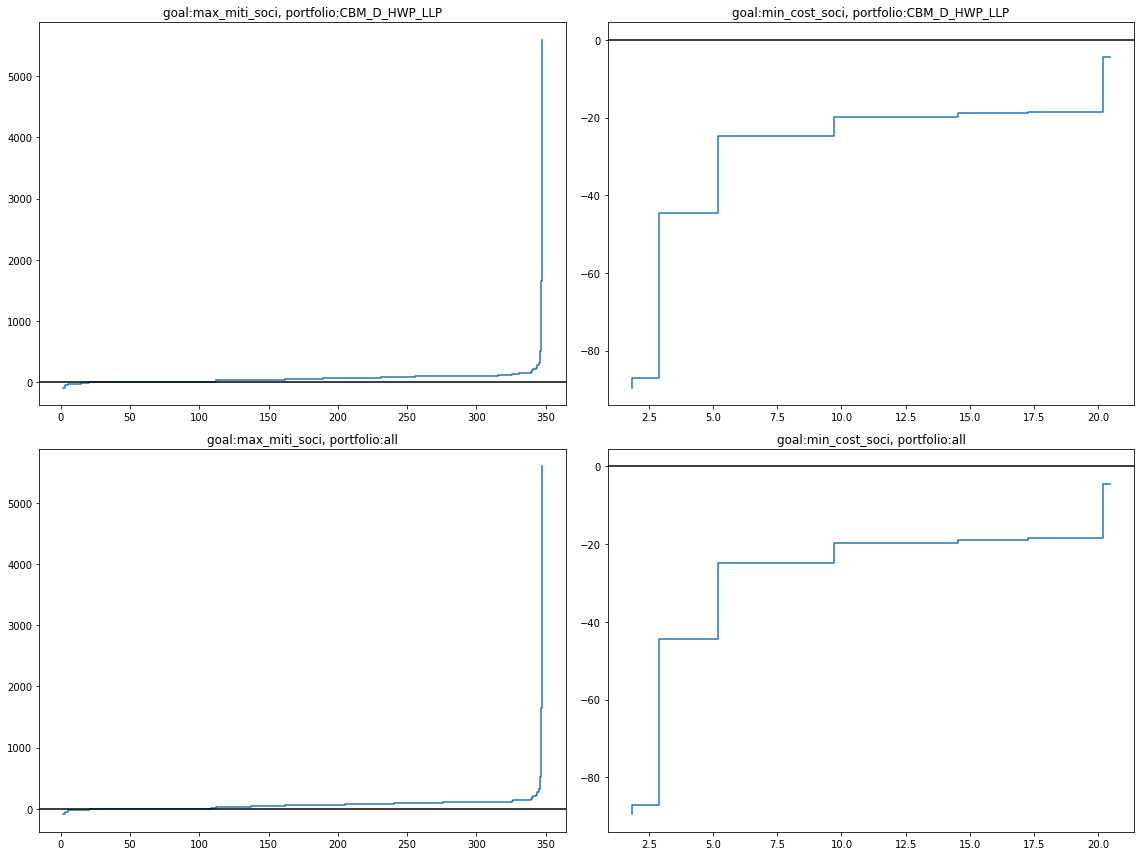

In [64]:
nrows, ncols, h, w, _sf = len(portfolios), len(goals), 3., 4., 2. 
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w*_sf, nrows*h*_sf))
for gid, goal in goals.items():
    for pid, portfolio in portfolios.items():
        df = r.loc[gid, pid].sort_values(by='unit_cost_soci')
        ax[pid][gid].step(x=-df['sum_tne'].cumsum(), y=df['unit_cost_soci'], where='pre')
        #ax[pid][gid].scatter(x=df['sum_dtne_soci'].cumsum(), y=df['unit_cost_soci'])
        #df.plot(x=df['sum_dtne_soci'].cumsum(), y='unit_cost_soci', ax=ax[pid][gid], kind='step')
        ax[pid][gid].set_title('goal:%s, portfolio:%s' % (goals[gid]['label'], portfolios[pid]['label']))
        ax[pid][gid].axhline(y=0, color='k')
        
plt.tight_layout()
plt.savefig('macc.pdf', format='pdf')